In this notebook, we will explore how to use pytorch to build a neural network model to predict survivorship on Titanic. 

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

## Loading the data

In [2]:
df = pd.read_csv("../data/Titanic/train_processed.csv")
df.shape

(889, 10)

In [3]:
train_df = df[:int(0.8 * len(df))]
valid_df = df[int(0.8 * len(df)):]

In [4]:
len(train_df), len(valid_df)

(711, 178)

In [5]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_numeric,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,0,0,1
1,1,1,38.0,1,0,71.2833,1,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,1
4,0,3,35.0,0,0,8.0500,0,0,0,1


## Define the model

Suppose we want to create a simple model with 1 middle layer that has 5 neurons. In pytorch, to create a model, we need to 
 - create a class that inherits nn.Module. 
 - the architecture (components) of the model will be defined in the constructor
 - the feed forward part needs to be defined in a function called forward. It tells how the data will flow through the network and how outputs are calculated

[Python class inheritance](https://www.w3schools.com/python/python_inheritance.asp)

In [6]:
class TitanticModel(nn.Module):
    def __init__(self): # self is like "this" in Java
        super().__init__()
        # we have 9 inputs and 5 outputs
        self.fc_layer_1 = nn.Linear(9, 5)
        # we will apply dropout on the layer with 20% of neuron getting dropped out each time
        self.dropout_layer = nn.Dropout(0.2)
        # next we need another layer to connect the 5 neurons to the 2 outputs
        self.fc_layer_2 = nn.Linear(5, 2)
        
    def forward(self, x):
        x = self.fc_layer_1(x)
        x = F.relu(x)
        x = self.dropout_layer(x)
        x = self.fc_layer_2(x)
        # softmax will make sure the sum of both neurons is 1
        # taking log because of mathmatical stability
        output = F.log_softmax(x, dim=1)
        return output

As you can see, defining a model in pytorch is more complex compared to Scikit-learn. However this means there's more flexibility and freedom of how you define your models

## Loading the data into dataset and dataloader

Unlike scikit-learn where you can directly pass in pandas dataframe or numpy array into model training, we need to pass data into a dataset object then dataloader instead

To define our customized dataset, there are three requirements: 
- we will initialize the class with the content of the data
- we need to implement the len dunder function to tell pytorch how large our dataset is
- we need to implemnt the getitem function to tell pytorch how to get a piece of data

[Python Dunder methods](https://mathspp.com/blog/pydonts/dunder-methods#:~:text=In%20Python%2C%20dunder%20methods%20are,__%20or%20__add__%20.)

In [7]:
class TitanicDataset(Dataset):
    def __init__(self, df):
        super().__init__()
        y = df['Survived'].values
        x = df.drop(['Survived'], axis=1).values
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [8]:
train_loader = torch.utils.data.DataLoader(TitanicDataset(train_df), batch_size=10, shuffle=True)
test_loader = torch.utils.data.DataLoader(TitanicDataset(valid_df), batch_size=10, shuffle=False)

In PyTorch, the batch size is the number of samples that are processed by the model in one forward-backward pass. It is one of the hyperparameters that needs to be set when training a model with a DataLoader.

When the batch size is set to 1, the model processes one sample at a time, which is called online or stochastic training. When the batch size is set to the size of the entire dataset, the model processes the entire dataset in one forward-backward pass, which is called batch training. In practice, the batch size is usually set to a value between 1 and the size of the dataset, and is a trade-off between the accuracy of the gradient and the speed of training. A larger batch size can lead to faster training, but may also lead to a less accurate gradient.

For example, if you have a dataset of 100 samples and you set the batch size to 10, the DataLoader will return 10 samples at a time, and it will take 10 iterations to process the entire dataset.

It's important to note that the batch size can also affect the memory usage during the training and inference, as the model needs to hold all the batch data in memory. So it's important to choose a batch size that fits the amount of memory available.

In [9]:
# for i, (data, labels) in enumerate(train_loader):
#     print(data.shape, labels.shape)
#     print(data,labels)

## Define the training and validation process

In [10]:
train_losses = []
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # this is to ensure each gradients calculated each batch are independent
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.item()
        loss.backward() ## calculate gradients
        optimizer.step() ## update the parameters using gradients
            
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f'Train Epoch: {epoch}, Loss: {train_loss:.6f}')

In [11]:
test_losses = []
def valid(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('Test set: Average loss: {:.4f}\n'.format(test_loss))

In [12]:
model = TitanticModel()
optimizer = optim.Adam(model.parameters(), lr=0.05)

for epoch in range(1, 20 + 1):
    train(model,train_loader, optimizer, epoch)
    valid(model, test_loader)


Train Epoch: 1, Loss: 0.079211
Test set: Average loss: 0.0701

Train Epoch: 2, Loss: 0.064664
Test set: Average loss: 0.0721

Train Epoch: 3, Loss: 0.068417
Test set: Average loss: 0.0657

Train Epoch: 4, Loss: 0.067798
Test set: Average loss: 0.0657

Train Epoch: 5, Loss: 0.067915
Test set: Average loss: 0.0662

Train Epoch: 6, Loss: 0.068246
Test set: Average loss: 0.0666

Train Epoch: 7, Loss: 0.068773
Test set: Average loss: 0.0672

Train Epoch: 8, Loss: 0.068270
Test set: Average loss: 0.0671

Train Epoch: 9, Loss: 0.067791
Test set: Average loss: 0.0657

Train Epoch: 10, Loss: 0.068478
Test set: Average loss: 0.0659

Train Epoch: 11, Loss: 0.068268
Test set: Average loss: 0.0662

Train Epoch: 12, Loss: 0.068541
Test set: Average loss: 0.0657

Train Epoch: 13, Loss: 0.067806
Test set: Average loss: 0.0668

Train Epoch: 14, Loss: 0.067833
Test set: Average loss: 0.0658

Train Epoch: 15, Loss: 0.068615
Test set: Average loss: 0.0680

Train Epoch: 16, Loss: 0.068435
Test set: Average

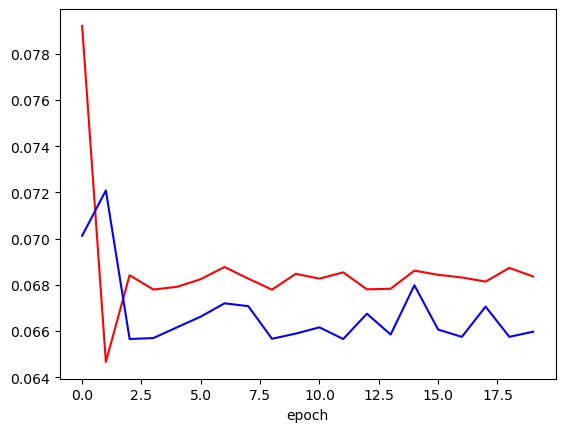

In [13]:
plt.plot(train_losses, color='r')
plt.plot(test_losses, color='b')
plt.xlabel("epoch")
plt.show()

In [14]:
y_pred = []
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        y_pred.append(pred.squeeze())

In [15]:
y_pred = torch.concat(y_pred)

In [16]:
model

TitanticModel(
  (fc_layer_1): Linear(in_features=9, out_features=5, bias=True)
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (fc_layer_2): Linear(in_features=5, out_features=2, bias=True)
)

In [17]:
model.state_dict()

OrderedDict([('fc_layer_1.weight',
              tensor([[-0.0784, -0.4944, -0.3044, -0.4909, -0.2177, -0.6262, -0.3448,  0.1724,
                       -0.0981],
                      [-0.2590, -0.2664,  0.2244, -0.1189, -0.1414, -0.0939,  0.1945, -0.1552,
                       -0.0347],
                      [ 0.5102, -0.1285, -0.3010, -0.5997, -0.3424, -2.5754,  0.2211, -0.8801,
                       -0.1446],
                      [-0.7940, -0.4366, -0.5323, -0.2306, -0.0388, -0.1433, -0.5214, -0.3805,
                       -0.9226],
                      [-0.2457, -0.3633, -0.5413,  0.0821, -0.1718,  0.1331, -0.7682, -0.1962,
                       -0.3992]])),
             ('fc_layer_1.bias',
              tensor([-0.6032, -0.0493, -0.1457, -0.6768, -0.2901])),
             ('fc_layer_2.weight',
              tensor([[-0.1022,  0.2057,  0.1387,  0.2834,  0.2444],
                      [ 0.3351, -0.3251,  0.0057,  0.2154,  0.4606]])),
             ('fc_layer_2.bias', tensor([ 0